# Extract $\alpha_s$ from lattice 

In [1]:
from adlerpy.adler_sm import adler_charm_pert
from adlerpy.adler_sm import adler_bottom_pert
from adlerpy.adler_sm import adler_light_pert
from scipy.optimize import fsolve
from adlerpy.adler_routines import adler_o_masless_i_heavy
from adlerpy.adler_routines import alphas
from adlerpy.adler_routines import adler_massless_connected

from adlerpy.adler_routines import Particle
from scipy.integrate import quad
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd


#Here you define the SM particles 
up=Particle("up",x=[2.16*0.001,2,3],mudec=0.001,mpole=None,mpole_on=False)
down=Particle("down",x=[4.67*0.001,2,3],mudec=0.001,mpole=None,mpole_on=False)
strange=Particle("strange",x=[0.09203,2,3],mudec=0.001,mpole=None,mpole_on=False)
charm=Particle("charm",x=[1.273,1.273,4],mudec=2*1.273,mpole=1.67,mpole_on=False)
bottom=Particle("bottom",x=[4.18,4.18,5],mudec=2*4.18,mpole=4.25,mpole_on=False)
top=Particle("top",x=[164,164,6],mudec=164,mpole=164,mpole_on=False)
particle_list=[up,charm,down,strange,bottom,top] 

## pQCD Adler function

In [2]:
def adlertot(aZ,Mz,Q,particles,nloops,mulow,GG,qq):
    adlight=adler_light_pert(aZ=aZ,Mz=Mz,Q=Q,particles=particles,nloops=nloops,GG=GG,qq=qq,QED=False)
    adc=adler_charm_pert(aZ=aZ,Mz=Mz,Q=Q,particles=particles,mulow=mulow,mpole_on=False,nloops=nloops,GG=GG,QED=False)
    return adc+adlight


## Adler function from lattice QCD

In [3]:

def adlerlattice(Q,x): #as a Pade approximant x are the coefficients of the Pade
    a1=x[0]
    a2=x[1]
    a3=x[2]
    b1=x[3]
    b2=x[4]
    b3=x[5]
    Q2=Q*Q
    return   (12*np.pi**2*Q2*(-(a1*(-1 + b2*Q2**2 + 2*b3*Q2**3)) + 
           Q2*(a3*Q2*(3 + 2*b1*Q2 + b2*Q2**2) + a2*(2 + b1*Q2 - b3*Q2**3))))/(1 + b1*Q2 + b2*Q2**2 + b3*Q2**3)**2

def adlerlattice_grad(Q,x): #The gradient at each point to compute the error!
    def f(y):
        a1=y[0]
        a2=y[1]
        a3=y[2]
        b1=y[3]
        b2=y[4]
        b3=y[5]
        Q2=Q*Q
        return (12*np.pi**2*Q2*(-(a1*(-1 + b2*Q2**2 + 2*b3*Q2**3)) + 
           Q2*(a3*Q2*(3 + 2*b1*Q2 + b2*Q2**2) + a2*(2 + b1*Q2 - b3*Q2**3))))/(1 + b1*Q2 + b2*Q2**2 + b3*Q2**3)**2
    grad=[]
    dx=0.00001;
    for i in range(len(x)):
        xplus=np.array(x);
        xplus[i]=xplus[i]+dx;
        grad.append((f(xplus)-f(x))/dx)
    return grad

def adlerlat_error(Q): #Basic error propagation. 
    x=[0.1094,0.093,0.0039,2.85,1.03,0.0166]
    error=[0.0023,0.015,0.0006,0.22,0.19,0.0012]
    cov=[[1,0.455,0.17,0.641,0.351,0.0489],
     [0.455,1,0.823,0.946,0.977,-0.0934],
     [0.17,0.823,1,0.642,0.915,0.0667],
     [0.641,0.946,0.642,1,0.869,-0.044],
     [0.351,0.977,0.915,0.869,1,-0.115],
     [0.0489,-0.0934,0.0667,-0.044,-0.115,1]]
    grad=adlerlattice_grad(Q,x)
    for i in range(len(x)):
        grad[i]=grad[i]*error[i]
    return np.sqrt(np.dot(np.transpose(grad),np.dot(cov,grad)))

## Compare pQCD and Lattice

In [4]:
q_list = np.arange(np.sqrt(1.2),np.sqrt(7)+0.05,0.005)
#q_list = np.arange(np.sqrt(6),np.sqrt(7)+0.05,0.001)

x=[0.1094,0.093,0.0039,2.85,1.03,0.0166]
# I am going to use data frames to keep it a bit cleaner. 

GG=0.012;  # Gluon condensate
dGG=0.012; # Gluon condensate error 100%
qq=-0.0013 # quark condensate
dqq=0.0007 # quark condensate error
aZ=0.1185; # central value
Mz=91.1876
daZ=0.0016 # error
nloops=4;  # perturbative order alphas^5
mulow=1.273     

adms=[[],[],[]]
adlat=[[],[],[]]
aslat=[[],[],[]]
acharm=[]
alight=[]
for q in q_list:
        # Compute errors--------
        adcentral=adlertot(aZ,Mz,q,particles=particle_list,nloops=nloops,mulow=mulow,GG=GG,qq=qq) # central value
        adplusas=adlertot(aZ+daZ,Mz,q,particles=particle_list,nloops=nloops,mulow=mulow,GG=GG,qq=qq) # shift from alphas
        adpluspert=adlertot(aZ,Mz,q,particles=particle_list,nloops=nloops-1,mulow=mulow,GG=GG,qq=qq) # truncation error
        adplusGG=adlertot(aZ,Mz,q,particles=particle_list,nloops=nloops,mulow=mulow,GG=GG+dGG,qq=qq) # parametric shift GG
        adplusqq=adlertot(aZ,Mz,q,particles=particle_list,nloops=nloops,mulow=mulow,GG=GG,qq=qq+dqq) # parametric shift qq
        
        # Total error include the parametric error from the input -----
        error=np.sqrt((adplusas-adcentral)**2+(adpluspert-adcentral)**2+(adplusGG-adcentral)**2
                      +(adplusqq-adcentral)**2
                     )
        
        # Perturbative error just comming from the input paramerers 
        errorp=np.sqrt((adpluspert-adcentral)**2+(adplusGG-adcentral)**2
                       +(adplusqq-adcentral)**2
                     )
       
        a_lat=adlerlattice(q,x) 
        a_lat_err=adlerlat_error(q)
        acharm.append(adler_charm_pert(aZ,Mz,Q=q,particles=particle_list,mulow=mulow,mpole_on=False,nloops=nloops,GG=GG,QED=False))
        alight.append(adler_light_pert(aZ,Mz,Q=q,particles=particle_list,nloops=nloops,GG=GG,qq=qq,QED=False))
        for i in [-1,0,1]:
            adms[i+1].append(float(adcentral+i*error));
            adlat[i+1].append(a_lat+i*a_lat_err)
            func = lambda a :a_lat+i*np.sqrt(a_lat_err**2+errorp**2) - adlertot(float(a),Mz,q,particles=particle_list,nloops=nloops,GG=GG,mulow=mulow,qq=qq)
            asol = fsolve(func,0.1185)[0]
            aslat[i+1].append(asol)
            

## Let us do some plotting 

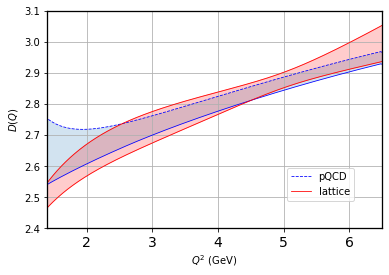

In [5]:
fig, ax = plt.subplots()
qplot=q_list**2
plt.plot(qplot,adms[2],color="blue",label="pQCD",linewidth=0.8)

plt.plot(qplot,adms[0],color="blue",linewidth=0.8)
plt.fill_between(qplot, np.array(adms[0]), np.array(adms[2]),alpha=0.2)

plt.plot(qplot,adlat[2],color="red",label="lattice",linewidth=0.8)
plt.plot(qplot,adlat[0],color="red",linewidth=0.8)
plt.fill_between(qplot, np.array(adlat[0]), np.array(adlat[2]),alpha=0.2,color="red")


#textstr = '\n'.join((
#    r'$\alpha_s(M_Z)=0.1185$',
#    r'$\hat{m}_c(\hat{m}_c)=1.274\,\mathrm{GeV}$',
#    r'$m^{\mathrm{pole}}_c=1.65\,\mathrm{GeV}$'))
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#place a text box in upper left in axes coords
#ax.text(0.3, 0.3, textstr, transform=ax.transAxes, fontsize=9,
#        verticalalignment='top', bbox=props)

ax.legend()
plt.grid()
plt.xticks(fontsize=14)
ax.spines['bottom'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['right'].set_linewidth(1.3)
plt.legend(bbox_to_anchor=(0.7, 0.3), loc='upper left')
ax.set(xlabel='$Q^2$ (GeV)', ylabel='$D(Q)$')
ax.set_xlim([1.4,6.5])
ax.set_ylim([2.4,3.1])

fig.savefig("pQCDvsLatticeAdler.png",dpi=600)
plt.show()

## Now let is plot the extracted $\alpha_s$

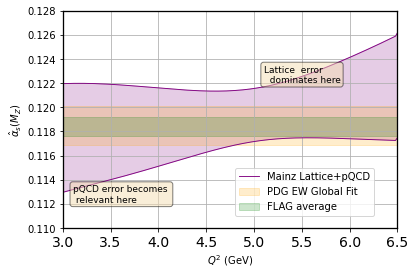

In [6]:
fig, ax = plt.subplots()
#plt.plot(qplot,aslat,color="blue",linewidth=0.8)
plt.plot(qplot,aslat[2],color="purple",linewidth=0.9)
plt.plot(qplot, aslat[0],color="purple",label="Mainz Lattice+pQCD",linewidth=0.9)
plt.fill_between(np.array(qplot), np.array(aslat[0]), np.array(aslat[2]),alpha=0.2,color="purple")

plt.fill_between(np.array(qplot), 0.1185+0.0016, 0.1185-0.0016,alpha=0.2,color="orange",label="PDG EW Global Fit")
plt.fill_between(np.array(qplot), 0.1184+0.0008, 0.1184-0.0008,alpha=0.2,color="green",label="FLAG average")

textstr = "pQCD error becomes \n relevant here"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#place a text box in upper left in axes coords
ax.text(0.03, 0.2, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

textstr = "Lattice  error \n  dominates here"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#place a text box in upper left in axes coords
ax.text(0.6, 0.75, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax.legend()
plt.grid()
plt.xticks(fontsize=14)
ax.spines['bottom'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['right'].set_linewidth(1.3)
plt.legend(bbox_to_anchor=(0.5, 0.3), loc='upper left')
ax.set(xlabel='$Q^2$ (GeV)', ylabel='$\hat{\\alpha}_s(M_Z)$')
ax.set_xlim([3,6.5])
ax.set_ylim([0.110,0.128])

fig.savefig("asfromlattice.png",dpi=600)
plt.show()

In [7]:
text=("\hat{\\alpha}_s(M_Z)= "+ str(round(aslat[1][181],4))+
      "\pm"+
      str(round((aslat[2][181]-aslat[1][181]),3))+
      "\,\,\, \mathrm{at}\,\,\, "+
      str(round(np.sqrt(qplot[181]),3))+
      "GeV"
     )
from IPython.display import display, Math
display(Math(text))

<IPython.core.display.Math object>